<a href="https://colab.research.google.com/github/ericksarraipo/Spark_Natural_Language_Processing/blob/main/Spark_Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Sessão e leitura dos dados**

In [ ]:
# Instalando o PySpark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=cb17fae6b48564238a6b8b119291fa18b57c13ce5f7492b8898593a113be2fd2
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# Iniciando uma sessão
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [ ]:
#Acessando os arquivos do drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# baixando o kaggle: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr
# Leitura dos dados:
# 1. Pela conexão com o google drive #2. Pelo carregamento no colab.(<---)
dados = spark.read.csv("/content/drive/MyDrive/Alura/imdb-reviews-pt-br.csv",
                       escape="\"",
                       header=True,
                       inferSchema=True)

### **Reviews de Notas de Filmes do IMDB**



#### **Explorando os dados**

In [ ]:
dados.count()

49459

In [ ]:
#qtd de colunas
print(f'Nº de Linhas: {dados.count()}', f'Nº de Colunas:{len(dados.columns)}')

Nº de Linhas: 49459 Nº de Colunas:4


In [ ]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [ ]:
dados.show(truncate = False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
dados.filter(dados.id == 190).select("text_pt").show(truncate = False)
print("Negativo")

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                          

In [ ]:
dados.filter(dados.id == 12427).select("text_pt").show(truncate = False)
print("Positivo")

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                                                                                                                                                                        

In [ ]:
#Qtd de comentarios post e negt
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



#### **Processamento dos dados**


1.  Limpeza dos Dados
2.  Remoção de StopWords
1.  Normalização






In [ ]:
#Criando World Cloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
#coletando uma amostra do tamanho de dados
#colocando a amostra em uma lista

amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)
tudo = [texto['text_pt'] for texto in amostra.collect()]
wordcloud = WordCloud().generate(str(tudo))

In [ ]:
#trazer as palavras individuais e em horizontal

wordcloud = WordCloud(background_color='white',
                                            width = 1000,
                                            height = 600,
                                            collocations = False,
                                            prefer_horizontal = 1).generate(str(tudo))

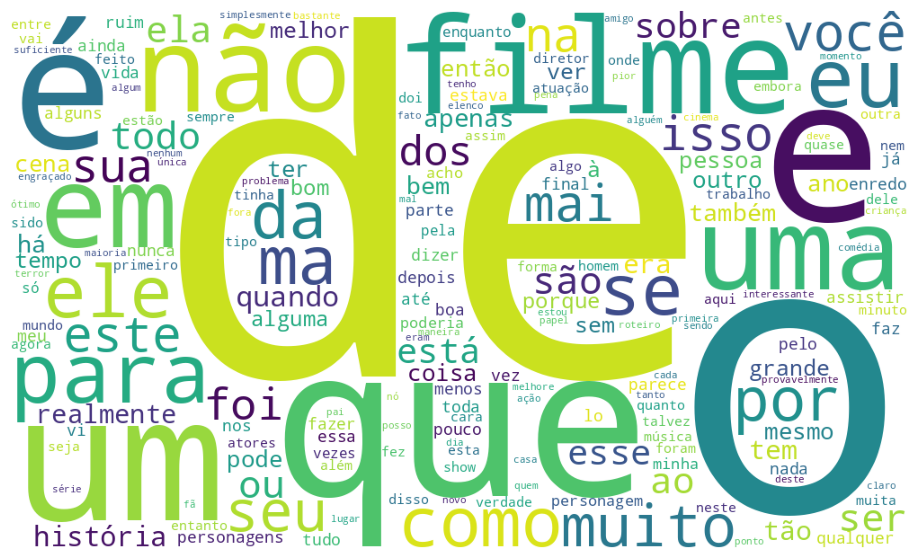

In [ ]:
plt.figure(figsize=(17,7))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### **Limpeza**: caracteres especiais




In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",)
        ], ["textos"])

In [ ]:
import pyspark.sql.functions as f

In [ ]:
amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))
amostra.show(truncate = False)

+------------------------------------------+-------------------------------+
|textos                                    |texto_regex                    |
+------------------------------------------+-------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |
|"bora *_* "                               |bora                           |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |
|{comprar: arroz; feijão e pepino} //      |comprar: arroz feijão e pepino |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |:[]                            |
|ana@gmail.com                             |anagmailcom                    |
+------------------------------------------+-------------------------------+



In [ ]:
#retirando os espaçoes em branco
amostra = amostra.withColumn("texto_limpo", f.trim(amostra.texto_regex))
amostra.show(truncate = False)

+------------------------------------------+-------------------------------+------------------------------+
|textos                                    |texto_regex                    |texto_limpo                   |
+------------------------------------------+-------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |Parabéns                      |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |amovc pazamor                 |
|"bora *_* "                               |bora                           |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |vc foi selecionad             |
|{comprar: arroz; feijão e pepino} //      |comprar: arroz feijão e pepino |comprar: arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`

In [ ]:
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))
dados.limit(2).show(truncate = False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#retirando os espaçoes em branco
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex))

#### **Tokenização**

In [ ]:
from pyspark.ml.feature import Tokenizer

In [ ]:
tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
tokenizado = tokenizer.transform(dados)

In [ ]:
tokenizado.select("texto_limpo", "tokens").show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [ ]:
from pyspark.sql.types import IntegerType

In [ ]:
#QTD de tokens que os comentários forma divididos.

countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado.select("texto_limpo", "tokens")\
          .withColumn("Freq_tokens", countTokens(f.col("tokens"))).show()


+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

#### **Stop Words**: biblioteca para reviews em português

In [ ]:
data2 = [(1, 'Spark é ótimo e NLP com Spark é fácil'),
                (0, 'Spark MLlib não ajuda muito'),
                (1, 'O MLlib do Spark ajuda e é fácil')]

colNames =['label', 'texto_limpo']

In [ ]:
import pyspark.sql
from pyspark.sql import Row

In [ ]:
df = spark.createDataFrame(data2, colNames)

In [ ]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_A = stopwords.words("portuguese")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from pyspark.ml.feature import StopWordsRemover

In [ ]:
stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")

In [ ]:
from pyspark.ml.feature import Tokenizer

In [ ]:
tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol= "tokens")
tokenized = tokenizer.transform(df)

In [ ]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final")

In [ ]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords = stop_A)

df = remover.transform(tokenized)

df.show(truncate = False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [ ]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords = stop_B)

df = remover.transform(tokenized)

df.show(truncate = False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [ ]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final")

feature_data = remover.transform(tokenized)

###Voltando para o Cod inicial do NLP

In [ ]:
#Retirando stopwords dos depoimentos

remover = StopWordsRemover(inputCol = "tokens", outputCol = "texto_final")
feature_data = remover.transform(tokenizado)

In [ ]:
feature_data = remover.transform(tokenizado)

In [ ]:
feature_data.limit(11).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|
|  5|B

In [ ]:
feature_data.select("tokens", "texto_final")\
                    .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
                    .withColumn("Fre_tokens_limpos", countTokens(f.col("texto_final"))).show()

+--------------------+--------------------+-----------+-----------------+
|              tokens|         texto_final|Freq_tokens|Fre_tokens_limpos|
+--------------------+--------------------+-----------+-----------------+
|[once, again, mr,...|[mr, costner, dra...|        168|               73|
|[this, is, an, ex...|[example, majorit...|        232|              131|
|[first, of, all, ...|[first, hate, mor...|        215|              111|
|[not, even, the, ...|[even, beatles, w...|        308|              169|
|[brass, pictures,...|[brass, pictures,...|        238|              140|
|[a, funny, thing,...|[funny, thing, ha...|        115|               52|
|[this, german, ho...|[german, horror, ...|        156|               74|
|[being, a, longti...|[longtime, fan, j...|        136|               73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|               75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|               99|
|[cage, plays, a, ...|[cage, plays, dr

#### **Análise Textual**

Bag Of Words

In [ ]:
from pyspark.ml.feature import CountVectorizer

In [ ]:
cv = CountVectorizer(inputCol = "texto_final", outputCol = "CountVec")


In [ ]:
model = cv.fit(feature_data)

countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select('texto_final', 'CountVec').limit(5).show()

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(221187,[0,7,8,11...|
|[example, majorit...|(221187,[1,2,3,8,...|
|[first, hate, mor...|(221187,[0,2,4,11...|
|[even, beatles, w...|(221187,[0,1,2,4,...|
|[brass, pictures,...|(221187,[1,3,5,8,...|
+--------------------+--------------------+



Hashing TF (Otimizando o Bag of Words)

In [ ]:
from pyspark.ml.feature import HashingTF

In [ ]:
hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HTFfeaturizedData = hashingTF.transform(countVectorizer_features)

In [ ]:
HTFfeaturizedData.select("texto_final", "hashingTF").limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



#### **TF-IDF**

In [ ]:
from pyspark.ml.feature import IDF

In [ ]:
idf = IDF(inputCol="hashingTF", outputCol="features")

In [ ]:
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [ ]:
TFIDFfeaturizedData.select('texto_final', 'features').limit(5).show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### **Pipeline de transformação**

In [ ]:
TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [ ]:
from pyspark.ml.feature import StringIndexer

In [ ]:
stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")

In [ ]:
dados = stringindexer.fit(dados).transform(dados)

In [ ]:
#Quem é 0 e quem é 1 ?

dados.groupBy(['sentiment', 'label']).count().show()


+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



Unindo as transformações

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")

In [ ]:
pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])

In [ ]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [ ]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

### **Modelos de Classificação**

In [ ]:
featureDF = dados_transformados.select(['features', 'label'])

In [ ]:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

In [ ]:
#Pipeline de Transformação e ajuste

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, dt])

### **Treino e Teste**

In [ ]:
train, test = dados.randomSplit([0.7, 0.3], seed = 101)

In [ ]:
dt_model = pipeline.fit(train)

In [ ]:
predictions = dt_model.transform(test)

In [ ]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...| [369.0,1108.0]|[0.24983073798239...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

### **Teste e Métricas**

In [ ]:
#as duas colunas que nos interessam
predictions.select(['label', 'prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
acuracia = evaluator.evaluate(predictions)

In [ ]:
print("Acuracia = %s" % (acuracia))

Acuracia = 0.6724696356275304


In [ ]:
#Classificando uma nova frase com base no modelo de Classificação Arvore de Decisão

nova_base = spark.createDataFrame([
        (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
        (0, "I loved the movie, excellent acting!"),
    ], ["id", "texto_limpo"])

In [ ]:
nova_class = dt_model.transform(nova_base)

In [ ]:
nova_class.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 HTF|            features|rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...|   [32.0,7.0]|[0.82051282051282...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[173.0,839.0]|[0.17094861660079...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+

